In [1]:
!jupyter nbextension enable jupyter_tabnine --py

!jupyter serverextension enable --py jupyter_tabnine

Enabling notebook extension jupyter_tabnine/main...
      - Validating: ok
Enabling: jupyter_tabnine
- Writing config: C:\Users\Arpan\.jupyter
    - Validating...
      jupyter_tabnine  ok


In [2]:
import pandas as pd
import os
import csv
import numpy as np
import seaborn as sns

import random
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from shapely.geometry import  LineString


from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Layer , Input , Flatten , LSTM , Dense
from tensorflow.keras.metrics import Precision, Recall , Accuracy
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

Each genuine/forgery signature is stored in a separate text file.
The file names are in the format "USERx_y.txt", where x (1..5)
indicates the user and y (1..40) indicates one signature instance
of the corresponding user, with the first 20 (1..20) representing
genuine signatures and the rest (21..40) representing skilled
forgeries provided by the other users.


## 1. Defining the Functions which will be used as a feature of signatures

In [3]:
def derivative(x , t):
    der = x.diff()/t.diff()
    return der        

In [4]:
def five_window(data):    
    k=0
    ls = []
    while k < len(data):
        if k < len(data)-4:
            max_ = max(data[k],data[k+1],data[k+2],data[k+3],data[k+4])
            min_ = min(data[k],data[k+1],data[k+2],data[k+3],data[k+4])
            ls.append(min_/max_)
            
        else :
            max_ = max(data[k],data[k-1],data[k-2],data[k-3],data[k-4])
            min_ = min(data[k],data[k-1],data[k-2],data[k-3],data[k-4])
            
            ls.append(min_/max_)
        k+=1
    return pd.Series(ls)

In [5]:
def five_window_ratio(data,data_y):    
    k=0
    ls = []
    while k < len(data):
        if k < len(data)-4:
            
            sum_ = np.sqrt((data[k]-data[k+1])**2 + (data_y[k] - data_y[k+1])**2)+np.sqrt((data[k+1]-data[k+2])**2 + (data_y[k+1] - data_y[k+2])**2)+np.sqrt((data[k+2]-data[k+3])**2 + (data_y[k+2] - data_y[k+3])**2)+np.sqrt((data[k+3]-data[k+4])**2 + (data_y[k+3] - data_y[k+4])**2)
            max_ = max(data[k],data[k+1],data[k+2],data[k+3],data[k+4])
            min_ = min(data[k],data[k+1],data[k+2],data[k+3],data[k+4])
            result = sum_/(max_-min_)
            ls.append(result)
            
        else :
            sum_ = np.sqrt((data[k]-data[k-1])**2 + (data_y[k] - data_y[k-1])**2)+np.sqrt((data[k-1]-data[k-2])**2 + (data_y[k-1] - data_y[k-2])**2)+np.sqrt((data[k-2]-data[k-3])**2 + (data_y[k-2] - data_y[k-3])**2)+np.sqrt((data[k-3]-data[k-4])**2 + (data_y[k-3] - data_y[k-4])**2)
            max_ = max(data[k],data[k-1],data[k-2],data[k-3],data[k-4])
            min_ = min(data[k],data[k-1],data[k-2],data[k-3],data[k-4])
            result = sum_/(max_-min_)
            ls.append(result)
        k+=1
    return pd.Series(ls)

In [6]:
def seven_window_ratio(data,data_y):    
    k=0
    ls = []
    while k < len(data):
        if k < len(data)-6:
            
            sum_ = np.sqrt((data[k]-data[k+1])**2 + (data_y[k] - data_y[k+1])**2)+np.sqrt((data[k+1]-data[k+2])**2 + (data_y[k+1] - data_y[k+2])**2)+np.sqrt((data[k+2]-data[k+3])**2 + (data_y[k+2] - data_y[k+3])**2)+np.sqrt((data[k+3]-data[k+4])**2 + (data_y[k+3] - data_y[k+4])**2)+np.sqrt((data[k+4]-data[k+5])**2 + (data_y[k+4] - data_y[k+5])**2)+np.sqrt((data[k+5]-data[k+6])**2 + (data_y[k+5] - data_y[k+6])**2)
            max_ = max(data[k],data[k+1],data[k+2],data[k+3],data[k+4],data[k+5],data[k+6])
            min_ = min(data[k],data[k+1],data[k+2],data[k+3],data[k+4],data[k+5],data[k+6])
            result = sum_/(max_-min_)
            ls.append(result)
            
        else :
            sum_ = np.sqrt((data[k]-data[k-1])**2 + (data_y[k] - data_y[k-1])**2)+np.sqrt((data[k-1]-data[k-2])**2 + (data_y[k-1] - data_y[k-2])**2)+np.sqrt((data[k-2]-data[k-3])**2 + (data_y[k-2] - data_y[k-3])**2)+np.sqrt((data[k-3]-data[k-4])**2 + (data_y[k-3] - data_y[k-4])**2)+np.sqrt((data[k-4]-data[k-5])**2 + (data_y[k-4] - data_y[k-5])**2)+np.sqrt((data[k-5]-data[k-6])**2 + (data_y[k-5] - data_y[k-6])**2)
            max_ = max(data[k],data[k-1],data[k-2],data[k-3],data[k-4],data[k-5],data[k-6])
            min_ = min(data[k],data[k-1],data[k-2],data[k-3],data[k-4],data[k-5],data[k-6])
            result = sum_/(max_-min_)
            ls.append(result)
        k+=1
    return pd.Series(ls)

## 2. Applying the functions to collect features from the main signature

In [7]:
def feature_collection(data):
    data['x_dot'] = derivative(data['X-coordinate'],data['Time stamp'])

    data['y_dot'] = derivative(data['Y-coordinate'],data['Time stamp'])

    data['pressure_dot'] = derivative(data['Pressure'],data['Time stamp'])

    data['altitude_dot'] = derivative(data['Altitude'],data['Time stamp'])

    data['azimuth_dot'] = derivative(data['Azimuth'],data['Time stamp'])

    data['path_tan_angle'] = np.arctan(data['y_dot']/data['x_dot'])

    data['path_velocity'] = np.sqrt((data['x_dot']**2+data['y_dot']**2))

    data['log_curve'] = np.log(abs(data['path_velocity']/derivative(data['path_tan_angle'],data['Time stamp'])))

    data['total_accelaration'] = np.sqrt(derivative(data['path_velocity'],data['Time stamp'])**2  + (derivative(data['path_tan_angle'],data['Time stamp'])*(data['path_velocity']))**2)

    data['path_tan_angle_dot'] = derivative(data['path_tan_angle'],data['Time stamp'])

    data['path_velocity_dot'] = derivative(data['path_velocity'],data['Time stamp'])

    data['log_curve_dot'] = derivative(data['log_curve'],data['Time stamp'])

    data['total_accelaration_dot'] = derivative(data['total_accelaration'],data['Time stamp'])

    data['x_dot_dot'] = derivative(data['x_dot'],data['Time stamp'])

    data['y_dot_dot'] = derivative(data['y_dot'],data['Time stamp'])

    data['min_max_v'] = five_window(data['path_velocity'])

    data['angle_of_two'] = np.arctan(derivative(data['y_dot'],data['x_dot']))

    data['angle_of_two_dot'] = derivative(data['angle_of_two'],data['Time stamp'])

    data['angle_of_two_sin'] = np.sin(data['angle_of_two'] )

    data['angle_of_two_cos'] = np.cos(data['angle_of_two'] )

    data['five_window'] = five_window_ratio(data['x_dot'],data['y_dot'])

    data['seven_window'] = seven_window_ratio(data['x_dot'],data['y_dot'])
    
    data.replace([np.inf, -np.inf], np.nan , inplace=True)

    data.fillna(0 , inplace=True)
    
    data.columns = ['X-coordinate','Y-coordinate','Time stamp','Button status','Azimuth','Altitude','Pressure','x_dot','y_dot','pressure_dot',
    'altitude_dot','azimuth_dot',
    'path_tan_angle','path_velocity',
    'log_curve','total_accelaration',
    'path_tan_angle_dot','path_velocity_dot',
    'log_curve_dot','total_accelaration_dot',
    'x_dot_dot','y_dot_dot','min_max_v',
    'angle_of_two','angle_of_two_dot','angle_of_two_sin',
    'angle_of_two_cos','five_window','seven_window'] 
    

    
    return data

## 3. Preprocessing of Signature data

In [8]:
def preprocess(data):
    
    
    scaler = MinMaxScaler()
    data[['X-coordinate', 'Y-coordinate', 'Button status',
       'Azimuth', 'Altitude', 'Pressure', 'x_dot', 'y_dot', 'pressure_dot',
       'altitude_dot', 'azimuth_dot', 'path_tan_angle', 'path_velocity',
       'log_curve', 'total_accelaration', 'path_tan_angle_dot',
       'path_velocity_dot', 'log_curve_dot', 'total_accelaration_dot',
       'x_dot_dot', 'y_dot_dot', 'min_max_v', 'angle_of_two',
       'angle_of_two_dot', 'angle_of_two_sin', 'angle_of_two_cos',
       'five_window', 'seven_window']] = scaler.fit_transform(data[['X-coordinate', 'Y-coordinate', 'Button status',
       'Azimuth', 'Altitude', 'Pressure', 'x_dot', 'y_dot', 'pressure_dot',
       'altitude_dot', 'azimuth_dot', 'path_tan_angle', 'path_velocity',
       'log_curve', 'total_accelaration', 'path_tan_angle_dot',
       'path_velocity_dot', 'log_curve_dot', 'total_accelaration_dot',
       'x_dot_dot', 'y_dot_dot', 'min_max_v', 'angle_of_two',
       'angle_of_two_dot', 'angle_of_two_sin', 'angle_of_two_cos',
       'five_window', 'seven_window']])
    scaler.fit(np.array(data['Time stamp']).reshape(-1, 1))
    scaler1 = MinMaxScaler(feature_range=(0,int(scaler.data_range_)))
    data['Time stamp'] = scaler1.fit_transform(np.array(data['Time stamp']).reshape(-1, 1))
    data.set_index('Time stamp', inplace = True)
    return data
    
    
    

## 4. Applying preprocessing function to each signature data

In [9]:
###########################################################################
### This part is only used for the first time to create the directories ###
########## Run for the first time and then make as comment again ##########
###########################################################################

# os.makedirs('feature_data')
# for file in os.listdir('Task2'): 
#     filena = file.split('.')
#     file_path = (os.path.join('Task2',file))
#     data = pd.read_csv(file_path, delimiter = ' ' ,skiprows = 1 ,header= None,)
#     data.columns = ['X-coordinate','Y-coordinate','Time stamp','Button status','Azimuth','Altitude','Pressure']     
#     feature_data = feature_collection(data)
    
#     preprocess_data = preprocess(feature_data)
    
#     print(f'{filena[0]}.csv')
#     preprocess_data.to_csv(f'feature_data/{filena[0]}.csv')    
    
    

## 5. Dividing the signatures

- There are two sets of signatures of each user. one is genuine and another is forged. each batch contains 20 signatures. total 40 signatures of each user 
- Now these signatures are divided into 3 sub folders for each user
- The genuine signatures are divided into two parts each of 10 signatures. one is positive and another is genuine signature for reference called anchor
- The forged signatures are kept into the negative folder

In [10]:
# # Creating folder 
POS_PATH = os.path.join('signature_data','positive')
NEG_PATH = os.path.join('signature_data','negative')
ANC_PATH = os.path.join('signature_data','anchor')

In [11]:
###########################################################################
### This part is only used for the first time to create the directories ###
########## Run for the first time and then make as comment again ##########
###########################################################################

# # Folders
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)


In [12]:
###########################################################################
### This part is only used for the first time to create the directories ###
########## Run for the first time and then make as comment again ##########
###########################################################################

# for file in os.listdir('feature_data'):
 
#     for i in range(1,100):
        
#         if file == f'U{i}S1.csv':
#             POS_PATH = os.path.join('signature_data','positive',f'User{i}')
#             NEG_PATH = os.path.join('signature_data','negative',f'User{i}')
#             ANC_PATH = os.path.join('signature_data','anchor',f'User{i}')
#             os.makedirs(POS_PATH)
#             os.makedirs(NEG_PATH)
#             os.makedirs(ANC_PATH)            
#         for pos in range(1,11):
            
#             if file == f'U{i}S{pos}.csv':
#                 ex_path = os.path.join('feature_data',file)
#                 new_path_pos = os.path.join(POS_PATH,file)
#                 os.replace(ex_path,new_path_pos)
                
                
#         for anc in range(11,21):
            
#             if file == f'U{i}S{anc}.csv':
#                 ex_path = os.path.join('feature_data',file)
#                 new_path_anc = os.path.join(ANC_PATH,file)
#                 os.replace(ex_path,new_path_anc)
                
# #                 print(ex_path)
# #                 print(new_path)
        
#         for neg in range(21,41):
            
#             if file == f'U{i}S{neg}.csv':
#                 ex_path = os.path.join('feature_data',file)
#                 new_path_neg = os.path.join(NEG_PATH,file)
#                 os.replace(ex_path,new_path_neg)
                
# #                 print(ex_path)
# #                 print(new_path_neg)
        

In [13]:
file_path = 'signature_data/anchor/User11/U11S17.csv'
data = pd.read_csv('signature_data/anchor/User11/U11S17.csv',header = None , skiprows=1)



In [14]:
# # redefining folder paths

POS_PATH = os.path.join('signature_data','positive')
NEG_PATH = os.path.join('signature_data','negative')
ANC_PATH = os.path.join('signature_data','anchor')

## 6. Data Batch

- Now our goal is to take two signatures as a pair of (reference,positive) and (reference,negative) and label them as 1 and 0 respectively.
- then these pairs will be transfered to neural network for training

In [15]:
def data_path(user_id):
    
    anchor = tf.data.Dataset.list_files(ANC_PATH+"\\" + f"User{user_id}"+"\\*.csv")
    positive = tf.data.Dataset.list_files(POS_PATH+"\\" + f"User{user_id}"+"\\*.csv")
    negative = tf.data.Dataset.list_files(NEG_PATH+"\\" + f"User{user_id}"+"\\*.csv")
    positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
    negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
    data_zip = positives.concatenate(negatives)
    
    return data_zip 

In [16]:
data_zip = data_path(user_id = 7)

- As each signature of same user are not of same shape so to overcome this problem zero padding is done to each signature and make it of 1000 rows

In [17]:
def preprocess_twin(input__ , val__, label ):
    input_ = pd.read_csv(input__.decode(), header = None, skiprows=1)
    val_ = pd.read_csv(val__.decode(), header = None, skiprows=1)
    pad_level = 1000
    m_i ,_ = input_.shape
    m_i = pad_level - m_i
    m_v ,_ = val_.shape
    m_v = pad_level - m_v
    
    zeros_inp = pd.DataFrame(np.zeros((m_i , input_.shape[1])))
    zeros_val = pd.DataFrame(np.zeros((m_v , val_.shape[1])))
    
    input_ = pd.concat([input_,zeros_inp],ignore_index=True)
    val_ = pd.concat([val_,zeros_val],ignore_index=True)
    
    
    input_.drop(input_.columns[[0,3]], axis=1 , inplace = True)
    val_.drop(val_.columns[[0,3]], axis=1 , inplace = True)
    return ((input_),(val_),label)


In [18]:
def show_sign(input__ , val__, label):
    input_ = pd.read_csv(input__.decode(), header = None, skiprows=1)
    val_ = pd.read_csv(val__.decode(), header = None, skiprows=1)
    plt.figure(figsize = (10,3))
    plt.subplot(1,2,1)
    plt.plot(input_[1],input_[2], )
    plt.title('Reference Image',{'fontsize':20},y=-0.2)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1,2,2)
    plt.plot(val_[1],val_[2], )
    plt.title('Input Image',{'fontsize':20},y=-0.2)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    


In [19]:
example = data_zip.as_numpy_iterator().next()


In [20]:
preprocess_twin(*example)

(           1         2         4         5         6         7         8   \
 0    0.004363  0.981056  0.714286  0.000000  0.194934  0.096296  0.178938   
 1    0.000000  0.986924  0.742857  0.055556  0.188326  0.082469  0.194556   
 2    0.002026  0.990277  0.800000  0.055556  0.208150  0.102716  0.187863   
 3    0.010597  0.997318  0.771429  0.111111  0.245595  0.123457  0.197680   
 4    0.023375  1.000000  0.800000  0.111111  0.306167  0.136790  0.186078   
 5    0.040829  1.000000  0.828571  0.166667  0.363436  0.151605  0.178938   
 6    0.060464  0.996312  0.828571  0.166667  0.399780  0.158519  0.169121   
 7    0.081658  0.989941  0.857143  0.166667  0.440529  0.163457  0.161981   
 8    0.103319  0.981559  0.857143  0.166667  0.490088  0.158698  0.158655   
 9    0.124981  0.972171  0.885714  0.222222  0.518722  0.164938  0.153949   
 10   0.142902  0.962783  0.885714  0.222222  0.546256  0.153086  0.153949   
 11   0.158018  0.953730  0.885714  0.277778  0.558370  0.144198

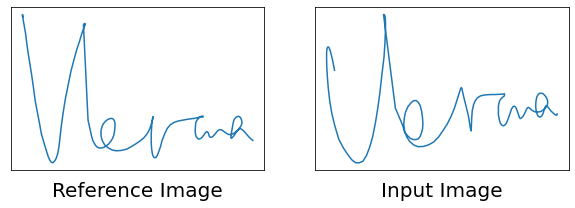

In [21]:
data_zip = data_path(user_id = 8)
example = data_zip.as_numpy_iterator().next()

show_sign(*example)

In [22]:
data_zip = data_path(user_id = 8)
data_zip = data_zip.cache()
data_zip = data_zip.shuffle(buffer_size = 1024)

train_data = data_zip.take(round(len(data_zip)*0.7))
train_data = train_data.batch(14)
train_data = train_data.prefetch(7)


test_data = data_zip.skip(round(len(data_zip)*0.7))
test_data = test_data.take(round(len(data_zip)*0.3))
test_data = test_data.batch(14)

In [24]:
# def embedding_model():
#     input_layer = Input(shape=[1000,27], name = 'input_signature')
#     Layer_1 = LSTM(54, activation = 'tanh' , recurrent_activation ='sigmoid' ,return_sequences=True , name = 'LSTM_layer_1')(input_layer)
    
#     Layer_2 = LSTM(27, activation = 'tanh' , recurrent_activation ='sigmoid', return_sequences=True,name = 'LSTM_layer_2')(Layer_1)
      
#     output_layer = Dense(27, activation="sigmoid" , name= 'Dense_layer')(Layer_2)
    
#     flat = (output_layer)
    
    
#     return Model(inputs=[input_layer] ,outputs = [output_layer], name = 'Input Parallel Pipelines')
    

In [25]:
# embedding = embedding_model()


In [26]:
# print(embedding.summary())


In [27]:
# tf.keras.utils.plot_model(embedding)

## 7. Required Neural Network Model 

In [28]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    
    def call(self , input_embed, validation_embed):
        return tf.math.abs(input_embed - validation_embed)
    

In [29]:
def siamese_model():
    
    input_layer = Input(shape=[1000,27],name ='input_data' )
    validation_layer = Input(shape=[1000,27] ,name = 'validation_data')
    
    Layer_1_1 = LSTM(54, activation = 'tanh' , recurrent_activation ='sigmoid' ,return_sequences=True , name = 'LSTM_layer_1_input')(input_layer)
    Layer_1_2 = LSTM(54, activation = 'tanh' , recurrent_activation ='sigmoid' ,return_sequences=True , name = 'LSTM_layer_1_validation')(validation_layer)
    
    Layer_2_1 = LSTM(27, activation = 'tanh' , recurrent_activation ='sigmoid', return_sequences=True,name = 'LSTM_layer_2_input')(Layer_1_1)
    Layer_2_2 = LSTM(27, activation = 'tanh' , recurrent_activation ='sigmoid', return_sequences=True,name = 'LSTM_layer_2_validation')(Layer_1_2)
      
    output_layer_1 = Dense(27, activation="sigmoid" , name= 'Dense_layer_input')(Layer_2_1)
    output_layer_2 = Dense(27, activation="sigmoid" , name= 'Dense_layer_validation')(Layer_2_2)
    
#     flat = (output_layer_1)
#     flat = (output_layer_2)
    
    
#     input_layer = Input(shape=[1000,27],name ='input_data' )
    
#     validation_layer = Input(shape=[1000,27] ,name = 'validation_data')
    
    siamese_layer = L1Dist()
    
    siamese_layer._name = 'L1_Distance_Layer'
    
#     embedding = embedding_model() 
    
    
    distances = siamese_layer(output_layer_1,output_layer_2)
    
    Layer_3 = LSTM(27, activation = 'tanh' , recurrent_activation ='sigmoid', return_sequences=True,name = 'LSTM_layer_3')(distances)
    
    flat_layer = Flatten(name='Flatten')(Layer_3)
    
    classification_layer = Dense(1 , activation = 'sigmoid', name='classification_layer')(flat_layer)
    
    return Model(inputs = [input_layer , validation_layer] , outputs = classification_layer , name = 'Siamese_Architecture')

In [30]:
siamese_ = siamese_model()

In [31]:
siamese_.summary()

Model: "Siamese_Architecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_data (InputLayer)        [(None, 1000, 27)]   0           []                               
                                                                                                  
 validation_data (InputLayer)   [(None, 1000, 27)]   0           []                               
                                                                                                  
 LSTM_layer_1_input (LSTM)      (None, 1000, 54)     17712       ['input_data[0][0]']             
                                                                                                  
 LSTM_layer_1_validation (LSTM)  (None, 1000, 54)    17712       ['validation_data[0][0]']        
                                                                               

## 8. Model Training

In [32]:
# tf.keras.utils.plot_model(siamese_)

In [33]:
def batch_fn(batch_1):

    inps=[]
    vals=[]
    batch_ls_y= []
    batch_1 = np.array(batch_1).T
    
    for i in batch_1:
        inp , val , label = (preprocess_twin(*i) )

        inps.append(inp)
        vals.append(val)

        batch_ls_y.append(label)

    return ([inps , vals , batch_ls_y])

In [34]:
siamese_ = siamese_model()
binary_cross_entropy = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.0001)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_)

def train_step(batch_):
    batch = batch_fn(batch_)
    loss_ls = []
    
    X = np.array(batch[:2])
       
    Y = np.array(batch[2]).reshape(-1,1)

    for x1,x2,y in zip(X[0],X[1],Y):
        with tf.GradientTape() as tape:
            
            x1 = x1.reshape(1,x1.shape[0],x1.shape[1])
            x2 = x2.reshape(1,x2.shape[0],x2.shape[1])
            y = y.reshape(1,y.shape[0])

            y_hat = siamese_([x1,x2] , training=True)

            loss = binary_cross_entropy(y, y_hat)
#             print(loss)
        

        grad = tape.gradient(loss, siamese_.trainable_variables)

        optimizer.apply_gradients(zip(grad, siamese_.trainable_variables))
    

    return loss

In [38]:
def ERR(yyy, yyyhat):
    cm = sklearn.metrics.confusion_matrix(yyy, yyyhat)
    tn, fp, fn, tp = cm.ravel()
    # False acceptance rate
    FAR = fp/(fp+tn)
    # False rejection rate
    FRR = fn/(tp+fn)
    return FAR,FRR 

In [39]:
def train(data_, EPOCHS):
    r = Recall()
    p = Precision()
    acc = Accuracy()
    recall = []
    precision = []
    accuracy = []
    loss_ = []
    genuine=[]
    imposter=[]
    far_list=[]
    frr_list=[]
    FAR,FRR=0,0
    count = 0
    y_true = []
    y_pred = []
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data_))
        
        # Loop through each batch
        ls = []
        for idx, batch in enumerate(data_):
            # Run train step here
            x1 , x2 , y_ = batch_fn(batch)
            x1 = np.array(x1)
            x2 = np.array(x2)
            loss = train_step(batch)
            yhat = siamese_.predict([x1,x2])
            r.update_state(y_, yhat)
            p.update_state(y_, yhat) 
            
            ypred = [1 if prediction >= 0.5 else 0 for prediction in yhat ]
            y_true.append(y_)
            y_pred.append(ypred)
            
            acc.update_state(y_, [1 if prediction >= 0.5 else 0 for prediction in yhat ]) 
            [genuine.append(round(float(prediction),4)) if prediction >= 0.5 else imposter.append(round(float(prediction),4)) for prediction in yhat ]            
            if count == 0:
                FAR = (FAR + ERR(y_,[1 if prediction >= 0.5 else 0 for prediction in yhat ])[0])
                FRR = (FRR + ERR(y_,[1 if prediction >= 0.5 else 0 for prediction in yhat ])[1])
            else:
                FAR = (FAR + ERR(y_,[1 if prediction >= 0.5 else 0 for prediction in yhat ])[0])/2
                FRR = (FRR + ERR(y_,[1 if prediction >= 0.5 else 0 for prediction in yhat ])[1])/2
#             print(y_,[1 if prediction >= 0.5 else 0 for prediction in yhat ],'count')
            
            count +=1 
            
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy(),acc.result().numpy())
        recall.append(r.result().numpy())
        precision.append(p.result().numpy())
        accuracy.append(acc.result().numpy())
        loss_.append(loss.numpy())
        far_list.append(FAR)
        frr_list.append(FRR)
    y_true = np.hstack(y_true) 
    y_pred = np.hstack(y_pred)
    return recall , precision , accuracy ,loss_ ,genuine ,imposter,far_list,frr_list,y_true,y_pred
        
#         # Save checkpoints
#         if epoch % 10 == 0: 
#             checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
# for idx, batch in enumerate(train_data):
#             # Run train step here
            
#             x1 , x2 , y_ = batch_fn(batch)
#             x1 = np.array(x1)
#             x2 = np.array(x2)
#             loss = train_step(batch)
#             yhat = siamese_.predict([x1,x2])
#             FAR = (FAR + ERR(y_,[1 if prediction >= 0.5 else 0 for prediction in yhat ])[0])
            
#             print(FAR)
#             break

In [41]:
recall , precision , accuracy , loss, genuine ,imposter,FAR_,FRR_,y_true,y_pred = train(train_data, EPOCHS=100)


 Epoch 1/100
1/1 [==============================] - 4s 4s/step
0.742557 1.0 0.5 0.5

 Epoch 2/100
1/1 [==============================] - 4s 4s/step
0.654545 1.0 0.52 0.5714286

 Epoch 3/100
1/1 [==============================] - 4s 4s/step
0.6645731 1.0 0.5833333 0.64285713

 Epoch 4/100
1/1 [==============================] - 4s 4s/step
0.6487272 1.0 0.6086956 0.6785714

 Epoch 5/100
1/1 [==============================] - 4s 4s/step
0.65157396 1.0 0.6181818 0.7

 Epoch 6/100
1/1 [==============================] - 4s 4s/step
0.61662906 1.0 0.6268657 0.70238096

 Epoch 7/100
1/1 [==============================] - 4s 4s/step
0.616254 1.0 0.6447368 0.7244898

 Epoch 8/100
1/1 [==============================] - 4s 4s/step
0.582125 1.0 0.6511628 0.73214287

 Epoch 9/100
1/1 [==============================] - 4s 4s/step
0.15330335 1.0 0.65957445 0.74603176

 Epoch 10/100
1/1 [==============================] - 4s 4s/step
0.5333017 1.0 0.6730769 0.75714284

 Epoch 11/100
1/1 [=================

1/1 [==============================] - 4s 4s/step
4.308781e-05 1.0 0.90705127 0.9494774

 Epoch 83/100
1/1 [==============================] - 4s 4s/step
0.00039447894 1.0 0.9079365 0.95008606

 Epoch 84/100
1/1 [==============================] - 4s 4s/step
0.00070434593 1.0 0.9089482 0.95068026

 Epoch 85/100
1/1 [==============================] - 4s 4s/step
0.00011272944 1.0 0.90979785 0.9512605

 Epoch 86/100
1/1 [==============================] - 4s 4s/step
0.00044255736 1.0 0.9107692 0.9518272

 Epoch 87/100
1/1 [==============================] - 4s 4s/step
0.0021946125 1.0 0.9117199 0.95238096

 Epoch 88/100
1/1 [==============================] - 4s 4s/step
5.545137e-05 1.0 0.9126506 0.9529221

 Epoch 89/100
1/1 [==============================] - 4s 4s/step
0.00024102505 1.0 0.9135618 0.95345104

 Epoch 90/100
1/1 [==============================] - 4s 4s/step
4.3222482e-07 1.0 0.9144543 0.9539682

 Epoch 91/100
1/1 [==============================] - 4s 4s/step
0.00013562098 1.0 0.

In [42]:
loss[-1],accuracy[-1],precision[-1],recall[-1],

(3.190286e-07, 0.95857143, 0.92266667, 1.0)

## 9. Testing Results

In [43]:
def test(test_data):
    test_batch = test_data.as_numpy_iterator()
    batch_2 = (test_batch.next())
    x1_ , x2_ , y_ = batch_fn(batch_2)
    predicted = []
    actual = []
    x1_ = np.array(x1_)
    x2_ = np.array(x2_)
    for x1,x2,y in zip(x1_,x2_,y_):
        plt.figure(figsize = (10,3))
        plt.subplot(1,2,1)
        plt.plot(x1.T[0],x1.T[1] )
        plt.title('Reference Image',{'fontsize':20},y=-0.2)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,2,2)
        plt.plot(x2.T[0],x2.T[1])
        plt.title('Input Image',{'fontsize':20},y=-0.2)
        plt.xticks([])
        plt.yticks([])
        plt.show()

        x1 = x1.reshape(1,x1.shape[0],x1.shape[1])
        x2 = x2.reshape(1,x2.shape[0],x2.shape[1])
        predicted.append((lambda i: 1 if i>=0.5 else 0)(siamese_.predict([x1,x2])))
        actual.append(y)
        print(siamese_.predict([x1,x2]))
        print(f"Actual Output : {y}")
        print(f"Predicted Output : {(lambda i: 1 if i>=0.5 else 0)(siamese_.predict([x1,x2]))}" )
        
    p = Precision()
    p.update_state(actual , predicted)
    print("\n\nPrecision :",p.result().numpy())

    m = Recall()
    m.update_state(actual , predicted)
    print("Recall :",m.result().numpy())
    return actual , predicted

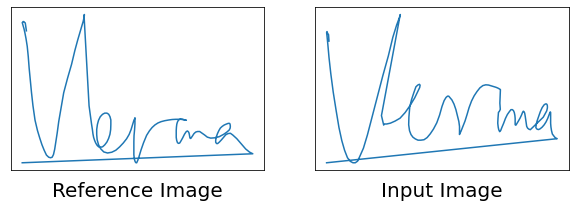

[[0.00039235]]
Actual Output : 0.0
Predicted Output : 0


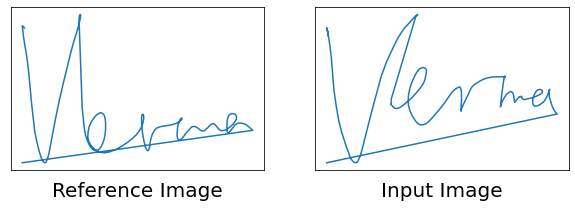

[[0.00062399]]
Actual Output : 0.0
Predicted Output : 0


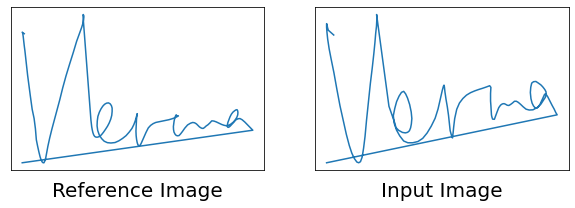

[[0.9993411]]
Actual Output : 1.0
Predicted Output : 1


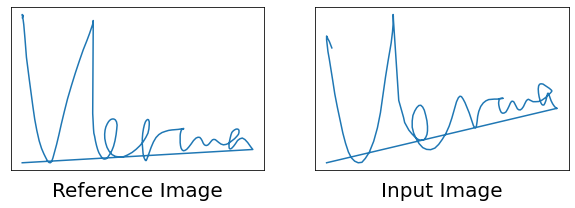

[[0.99973994]]
Actual Output : 1.0
Predicted Output : 1


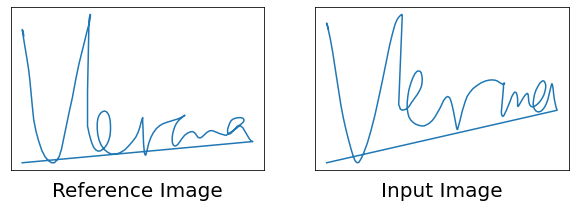

[[3.1790753e-07]]
Actual Output : 0.0
Predicted Output : 0


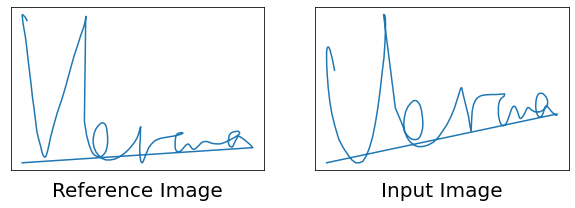

[[0.9993561]]
Actual Output : 1.0
Predicted Output : 1


Precision : 1.0
Recall : 1.0


In [44]:
y_true , y_pred = test(test_data)

## 10. Evaluation

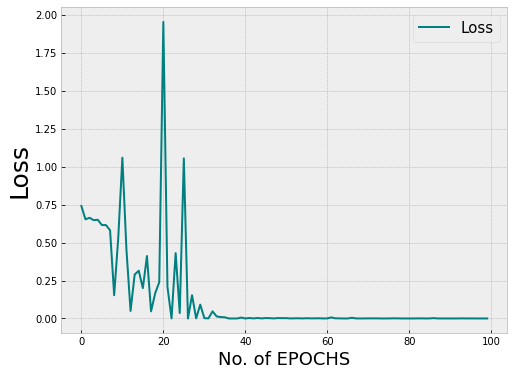

In [46]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))

plt.plot(loss,label ='Loss',color='teal')
# plt.title('Figure 1: Training Loss',fontsize=25,y=-.2)
plt.xlabel('No. of EPOCHS',fontsize=18)
plt.ylabel('Loss',fontsize=25)
plt.legend(loc=1,fontsize=15)

plt.show()

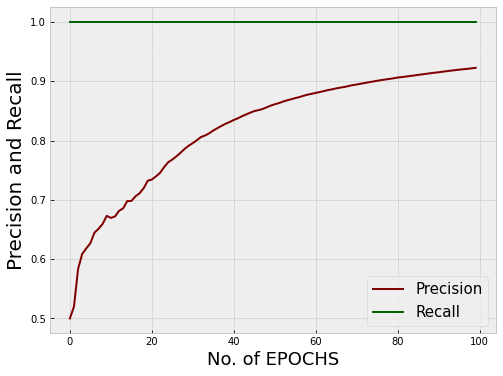

In [47]:
# plt.style.use('ggplot')
plt.figure(figsize=(8,6))

plt.plot(precision, label='Precision',color='maroon')
plt.plot(recall , label='Recall',color='darkgreen')
# plt.title('Figure 2: Precision and Recall for Training Data',fontsize=25,y=-.2)
plt.xlabel('No. of EPOCHS',fontsize=18)
plt.ylabel('Precision and Recall',fontsize=20)
plt.legend(loc=4,fontsize=15)
plt.show()

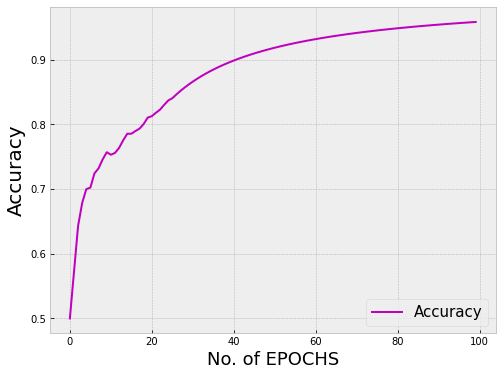

In [48]:
# plt.style.use('ggplot')
plt.figure(figsize=(8,6))

plt.plot(accuracy , label ='Accuracy',color='m')
# plt.title('Figure 3: Training Accuracy',fontsize=25,y=-.2)
plt.xlabel('No. of EPOCHS',fontsize=18)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(loc=4,fontsize=15)

plt.show()

C:\Users\Arpan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Arpan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


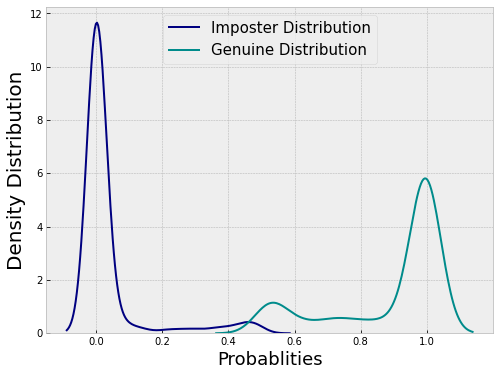

In [49]:
plt.figure(figsize=(8,6))

sns.distplot(imposter,color = 'navy',label='Imposter Distribution',hist=False)
sns.distplot(genuine,color='darkcyan',label='Genuine Distribution',hist=False)
plt.xlabel('Probablities',fontsize=18)
plt.ylabel('Density Distribution',fontsize=20)
plt.legend(loc=9,fontsize=15)

plt.show()

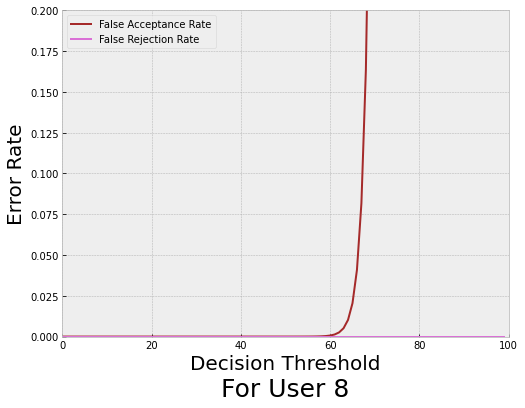

In [52]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))

plt.plot(np.sort(FAR_)*100, label='False Acceptance Rate',color='brown')
plt.plot(np.sort(FRR_)[::-1]*100 , label='False Rejection Rate',color='orchid')
# plt.plot(x,y, 'ro')
plt.title('For User 8',fontsize=25,y=-.2)

# plt.ylabel('Density Distribution',fontsize=20)
plt.xlabel('Decision Threshold',fontsize=20)
plt.ylabel('Error Rate',fontsize=20)


plt.legend(loc=9,fontsize=20)
plt.ylim([0, 2e-1])
plt.xlim([0,100])
plt.legend()
plt.show()

(0.0, 1e-10)

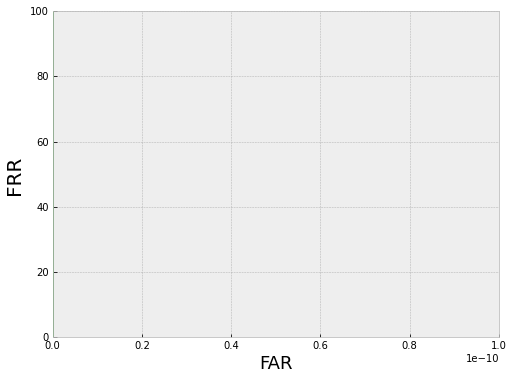

In [60]:
plt.figure(figsize=(8,6))

plt.plot(np.sort(FRR_)[::-1]*100,np.sort(FAR_)*100, label='ERR',color='green')
# plt.plot(yz,xz,'ro')
plt.xlabel('FAR',fontsize=18)
plt.ylabel('FRR ',fontsize=20)
plt.ylim([0, 100])
plt.xlim([0,1e-10])